###### Description: 
This notebook features a script for a single-node, deterministic, continuous time version of MGDrivE with genetics included. 

###### Improvement over MGDrivE: 
Checks equilibrium values with NLSolve; analytical solutions are used as "initial guesses." 

DiffEq with is used for the ODE implementation, employing callbacks for controlled release simulation. 

###### Releases for this version are tested using M.
(Previously, used F where [i,j] = [1,1] but this has arguable meaning given that j of F matrix = M genotype. Need to think more about this.) 

###### Next steps: 
(1) Create structs + develop new approach to "cube" (via structs?) 

(2) Update ArrayPartition usage for loops if the package is fixed (Chris R is on the case...)  

## Packages

In [1]:
using DifferentialEquations 
using NLsolve
#using Plots
#gr()
using LinearAlgebra
#using RecursiveArrayTools
#using ParameterizedFunctions
#using Sundials 
#using DiffEqSensitivity
;

# using DiffEqUncertainty

## Functions

In [2]:
#include("Modelling_TrialRuns/DraftDrive_Working1_Internal") #need to create julia files not jupyter notebooks 



## Utilities 

In [3]:
#= 
function create_pop()
    function ode_contNL(du, u, params, t)
end
=#

## Parameter values 

In [4]:

nG = 6     # number of potential genotypes (mostly used for accounting purposes in females, possibly other stuff too)

########### "Theta" list of parameters from 4/3/2019 version

β = 16.0   # fecundity
TE = 4     # Total stage duration 
qE = 1/TE  # "q" vars also called "r"; represent total time in each "bin"/substage  
nE = 4     # number of "bins"/substages in this stage 
μE = 0.05  # mortality aka probability of dying in this stage 

TL = 3     
qL = 1/TL
nL = 8
μL = 0.15

TP = 6
qP = 1/TP 
nP = 6
μP = 0.05 

NF = 500.0 
μF = 0.09 
μM = 0.09  
ϕ = 0.5    # gender 

########### Density dependence options 
γ = 0.001  # linear case; value from Hancock paper
K = 355.0  # logistic case; carrying capacity also listed as "1" elsewhere 

########### Include cube-related parameters
s = ones(6)
β_s = beta_s = β*s
τ = tau = ones(6,6,6)
η = ones(6)
# cube = see construction and values below
; 


## Calculate "guesses" for NLSolve

In [5]:
# Pupae
function init_P(NF, μF, nP, qP, ϕ, μP)  
    P0 = zeros(6)  
    P0[end] = (NF*μF) / (nP*qP*ϕ)    
    for i in length(P0)-1:-1:1
        P0[i] = ((μP + qP*nP)/(qP*nP)) * P0[i+1]
    end   
    return P0    
end


# Eggs
function init_E(β, NF, μE, qE, nE)
    # placeholder for each day of history 
    E0 = zeros(4)    
    # initialize at equilibrium  
    E0[1] = β*NF / (μE + qE*nE)   
    # obtain values for each day of history based on eq 
    for i in 2:length(E0)
        E0[i] = (qE*nE*E0[i-1]) / (μE + qE*nE)
    end    
    # show result
    return E0
end


# Larvae 
function init_L(μP, qP, nP, qL, nL, P0, qE, nE)  
    L0 = zeros(8)
    L0[end] = ((μP + qP*nP)/(qL*nL)) * P0[1] 
    Lend = L0[end]
    Eend = E0[end]  
    for i in length(L0)-1:-1:1
        L0[i] = ((Lend^(i/nL)) * (Eend^((nL-i)/nL)) * (nE^((nL-i)/nL)) * 
            (qE^((nL-i)/nL))) / ((nL^((nL-i)/nL)) * (qL^((nL-i)/nL)))
    end    
    return L0   
end


# Adult Males   
function init_NM(ϕ, qP, nP, P0, μM)
    NM = ((1-ϕ)*qP*nP*P0[end]) / μM
    return NM  
end

# Adult Females: EQ NOT CALCULATED; SIMPLY ASSIGNED A VALUE (NF = 500.0)

E0 = init_E(β, NF, μE, qE, nE)
P0 = init_P(NF, μF, nP, qP, ϕ, μP) 
L0 = init_L(μP, qP, nP, qL, nL, P0, qE, nE)
NM = init_NM(ϕ, qP, nP, P0, μM)

#= Check against comparison values from version of 4-3-2019: correct! 
$init
    E1         E2         E3         E4         L1         L2         L3         L4         L5         L6         L7 
7619.04762 7256.23583 6910.70079 6581.61980 1497.07910  908.08277  550.81547  334.10795  202.65975  122.92726 74.56395 
    L8         P1         P2         P3         P4         P5         P6         NF         NM 
45.22823  114.86534  109.39556  104.18625   99.22500   94.50000   90.00000  500.00000  500.00000 
=#
; 


## Create life stage structures; initialize with eq "guesses" (wildtype values)

In [6]:
# Empty structures
eggs = zeros(4,6)
larvae = zeros(8,6)
pupae = zeros(6,6)
NM = zeros(6)
NF = zeros(6,6)

# Format values from equilibrium equations above 
init_eggs = [7619.04  7256.24  6910.7  6581.62]'
init_larvae = [1497.08  908.083  550.815  334.108  202.66  122.927  74.5639  45.2282]'
init_pupae = [114.865  109.396  104.186  99.225  94.5  90.0]'

# Insert values 
eggs[:, 4] = init_eggs
larvae[:, 4] = init_larvae
pupae[:, 4] = init_pupae
NM[4] = 500.0
NF[4,4] = 500.0
;

In [7]:
# Put it together (transpose NM for shape alignment)
u0_orig = vcat(eggs, larvae, pupae, transpose(NM), NF)
;

typeof(u0_orig)

#u0_array = ArrayPartition(eggs, larvae, pupae, NM, NF)

Array{Float64,2}

## Build "ih" cube

In [8]:
# Create empty cube 
cube = zeros(6,6,6)  

# Make each layer 
layer1 = [1.0 1.0 0.50  0  0  0; 1.0 1.0 0.50  0  0  0; 0.5 0.5 0.25  0  0  0; 
        0.0 0.0 0.00  0  0  0; 0.0 0.0 0.00  0  0  0; 0.0 0.0 0.00  0  0  0]

layer2 = [0.0 0.0 0.00 1.0 0.50  0; 0.0 0.0 0.00 1.0 0.50  0; 0.0 0.0 0.00 0.5 0.25  0; 
        1.0 1.0 0.50 0.0 0.00  0; 0.5 0.5 0.25 0.0 0.00  0; 0.0 0.0 0.00 0.0 0.00  0]

layer3 = [0.0 0.0 0.50  0 0.50 1.0; 0.0 0.0 0.50  0 0.50 1.0; 0.5 0.5 0.50  0 0.25 0.5;
        0.0 0.0 0.00  0 0.00 0.0; 0.5 0.5 0.25  0 0.00 0.0; 1.0 1.0 0.50  0 0.00 0.0]

layer4 = [0  0  0 0.0 0.00  0; 0  0  0 0.0 0.00  0; 0  0  0 0.0 0.00  0; 
        0  0  0 1.0 0.50  0; 0  0  0 0.5 0.25  0; 0  0  0 0.0 0.00  0]

layer5 = [0  0  0 0.0 0.00  0; 0  0  0 0.0 0.00  0; 0  0 0.00 0.5 0.25 0.0; 
        0  0 0.50 0.0 0.50 1.0; 0  0 0.25 0.5 0.50 0.5; 0  0 0.00 1.0 0.50 0.0]

layer6 = [0  0  0 0.0 0.00  0; 0  0  0 0.0 0.00  0; 0  0 0.25  0 0.25 0.5; 
        0  0 0.00  0 0.00 0.0; 0  0 0.25  0 0.25 0.5; 0  0 0.50  0 0.50 1.0]

# Populate the cube 
cube[:,:,1] = layer1
cube[:,:,2] = layer2
cube[:,:,3] = layer3
cube[:,:,4] = layer4
cube[:,:,5] = layer5
cube[:,:,6] = layer6

# Each cell of "check" should add to one if correct
check = layer1 + layer2 + layer3 + layer4 + layer5 + layer6  
;


In [9]:
nM = 1
gN = 6 # later iterations have this from genetics struct -> number of genotypes always = "length" of females

6

In [10]:
nE+1

5

## Use NLSolve to check eq values

In [11]:
function init(du, u, params, t)

    ##################
    # Parameters 
    ##################
    
    nG, qE, nE, μE, qL, nL, μL, qP, nP, μP, μF, μM, ϕ, β, γ, s, τ, cube, η, K = params 
    
    ##################
    # State space
    ##################
    
    # Question -> how to make the legnth of each stage flexible in the absence of ArrayPartitions? 
    # Thought1: length(stage) for juvenile x3, length(genes) for female, and always = 1 for males. 
    # Thought2: @show size(du)
    
    
    # Eggs 
    E = u[1:4,:]
    dE = du[1:4,:]
    
    # Larvae
    L = u[5:12,:]
    dL = du[5:12,:]

    # Pupae
    P = u[13:18,:]
    dP = du[13:18,:]
    
    # Males 
    NM = u[19,:]
    dNM = du[19,:]
    
    # Females 
    NF = u[20:25,:]
    dNF = du[20:25,:]
    
    
    ##################
    # Equations 
    ##################
    
    # Loop over genes in each life stage & substage  
    for j in 1:6    
        
        ## Oviposition 
        #@show size(cube[:,:,j].*τ[:,:,j].*s*β.*NF)
        eggsnew = sum(cube[:,:,j].*τ[:,:,j].*s*β.*NF)
          
        #@show eggsnew 
        
        ## Eggs
        dE[1,j] = eggsnew - E[1,j]*(μE + qE*nE) 
        
        for i in 2:size(dE)[1]  
            dE[i,j] = qE*nE*E[i-1,j] - E[i,j]*(μE + qE*nE)
        end
        
        
        ##Larvae 
        dL[1,j] = qE*nE*E[end,j] - L[1,j]*(μL*(1 + (sum(L)/K)) + qL*nL)

        
        for i in 2:size(dL)[1]
            dL[i,j] = qL*nL*L[i-1,j] - L[i,j]*(μL*(1 + (sum(L)/K)) + qL*nL)
        end
        
     
        ## Pupae 
        dP[1,j] = qL*nL*L[end, j] - P[1,j]*(μP + qP*nP)
        
        for i in 2:size(dP)[1]
            dP[i,j] = qP*nP*P[i-1,j] - P[i,j]*(μP + qP*nP)
        end
        
        
        ## Males 
        if j == 1
            dNM[j] = (1-ϕ)*qP*nP*P[end,j] - μM*NM[j]
        else
            dNM[j] = (1-ϕ)*qP*nP*P[end,j] - μM*NM[j]
        end
        
        #@show t, u.f1
    
        ## Mating
        nowmate = NM.*η
        nowmate = normalize(nowmate)
        matematrix = nowmate*(ϕ*qP*nP*P[end,:]')
            
        #@show matematrix

    
        ## Females
        for i in 1:size(dNF)[1]

                dNF[i,j] = matematrix[i,j] - μF*NF[i,j]   
        
        end # for i loop (females)

    end #for j loop (genes)   

end # for function 


# same params as used elswhere in this notebook 
params = [nG, qE, nE, μE, qL, nL, μL, qP, nP, μP, μF, μM, ϕ, β, γ, s, τ, cube, η, K]

# New u0 calculated using NLSolve -> use previous u0 as initial "guesses"
nlsol = nlsolve((du,u) -> init(du, u, params, 0), u0_orig);

# Examine "new" u0 
u0_new = nlsol.zero 

;

In [12]:
u0_new

25×6 Array{Float64,2}:
 0.0  0.0  0.0  7619.04    0.0  0.0
 0.0  0.0  0.0  7256.24    0.0  0.0
 0.0  0.0  0.0  6910.7     0.0  0.0
 0.0  0.0  0.0  6581.62    0.0  0.0
 0.0  0.0  0.0  1497.08    0.0  0.0
 0.0  0.0  0.0   908.083   0.0  0.0
 0.0  0.0  0.0   550.815   0.0  0.0
 0.0  0.0  0.0   334.108   0.0  0.0
 0.0  0.0  0.0   202.66    0.0  0.0
 0.0  0.0  0.0   122.927   0.0  0.0
 0.0  0.0  0.0    74.5639  0.0  0.0
 0.0  0.0  0.0    45.2282  0.0  0.0
 0.0  0.0  0.0   114.865   0.0  0.0
 0.0  0.0  0.0   109.396   0.0  0.0
 0.0  0.0  0.0   104.186   0.0  0.0
 0.0  0.0  0.0    99.225   0.0  0.0
 0.0  0.0  0.0    94.5     0.0  0.0
 0.0  0.0  0.0    90.0     0.0  0.0
 0.0  0.0  0.0   500.0     0.0  0.0
 0.0  0.0  0.0     0.0     0.0  0.0
 0.0  0.0  0.0     0.0     0.0  0.0
 0.0  0.0  0.0     0.0     0.0  0.0
 0.0  0.0  0.0   500.0     0.0  0.0
 0.0  0.0  0.0     0.0     0.0  0.0
 0.0  0.0  0.0     0.0     0.0  0.0

## Create mutable struct employing DEDataVectors

In [13]:
mutable struct SimType{T} <: DEDataMatrix{T}
    x::Array{T,2}
    f1::T
end

# x::ArrayPartition{T}

## Define initial conditions for u.f1 and larger problem 

In [14]:
# Include the starting point for u.f1 in u0: 
u0 = SimType(u0_new, 0.0)

tspan = (0.0,30.0) 

params = [nG, qE, nE, μE, qL, nL, μL, qP, nP, μP, μF, μM, ϕ, β, γ, s, τ, cube, η, K]

typeof(u0)
;

## Create modified (u.f1) ODE function

In [15]:
function ode_contNL(du, u, params, t)
    
    ##################
    # State space
    ##################
    
    # view(du, 1:4, :) -> constructs abstract syntax tree 
    # macro = like a function but runs earlier than the code 
    # macro runs only once 
    
    ###### NB: [nE+1 : nE+nL]  can't do arithmetic to fix length of each stage; throws error: "nE" etc not recognized
    
    # Eggs 
    E = u[1:4,:]
    dE = @view du[1:4,:]
    
    # Larvae
    L = u[5:12,:]
    dL = @view du[5:12,:]

    # Pupae
    P = u[13:18,:]
    dP = @view du[13:18,:]
    
    # Males 
    NM = u[19,:]
    dNM = @view du[19,:]
    
    # Females 
    NF = u[20:25,:]
    dNF = @view du[20:25,:]
    
    
    ##################
    # Parameters 
    ##################
    
    nG, qE, nE, μE, qL, nL, μL, qP, nP, μP, μF, μM, ϕ, β, γ, s, τ, cube, η, K = params 
    
    
    ##################
    # Equations 
    ##################
    
    # Loop over genes in each life stage & substage  
    for j in 1:6    
        
        ## Oviposition 
        eggsnew = sum(cube[:,:,j].*τ[:,:,j].*s*β.*NF)
        ## Eggs
         @show j, t, "  ", cube[:,:,j].*τ[:,:,j].*s*β.*NF
        dE[1,j] = eggsnew - E[1,j]*(μE + qE*nE) 
        
        for i in 2:size(dE)[1]  
            dE[i,j] = qE*nE*E[i-1,j] - E[i,j]*(μE + qE*nE)
        end
        
        ##Larvae 
        dL[1,j] = qE*nE*E[end,j] - L[1,j]*(μL*(1 + (sum(L)/K)) + qL*nL)

        
        for i in 2:size(dL)[1]
            dL[i,j] = qL*nL*L[i-1,j] - L[i,j]*(μL*(1 + (sum(L)/K)) + qL*nL)
        end
        
     
        ## Pupae 
        dP[1,j] = qL*nL*L[end, j] - P[1,j]*(μP + qP*nP)
        
        for i in 2:size(dP)[1]
            dP[i,j] = qP*nP*P[i-1,j] - P[i,j]*(μP + qP*nP)
        end
        
        
        ## Males 
        if j == 1
            dNM[j] = (1-ϕ)*qP*nP*P[end,j] - μM*NM[j] + u.f1
        else
            dNM[j] = (1-ϕ)*qP*nP*P[end,j] - μM*NM[j]
        end
        
        #@show t, u.f1
    
        ## Mating
        nowmate = NM.*η
        nowmate = normalize(nowmate)
        matematrix = nowmate*(ϕ*qP*nP*P[end,:]')
    
        ## Females
        for i in 1:size(dNF)[1]

                dNF[i,j] = matematrix[i,j] - μF*NF[i,j] 
        
        end # for i loop (females)

    end #for j loop (genes)   

end # for function 


ode_contNL (generic function with 1 method)

## Set up control mechanism

In [16]:
# Time points at which f1 will change 
const tstop1 = [25.]
const tstop2 = [26.]
const tstop3 = [35.]
const tstop4 = [36.]
const tstop5 = [45.]
const tstop6 = [46.]
const tstop7 = [55.]
const tstop8 = [56.]
const tstop9 = [65.]
const tstop10 = [66.]

# Use DiscreteCallback interface to encode the conditions 
function condition1(u, t, integrator)
    t in tstop1
end

function condition2(u, t, integrator)
    t in tstop2
end

function condition3(u, t, integrator)
    t in tstop3
end

function condition4(u, t, integrator)
    t in tstop4
end

function condition5(u, t, integrator)
    t in tstop5
end

function condition6(u, t, integrator)
    t in tstop6
end

function condition7(u, t, integrator)
    t in tstop7
end

function condition8(u, t, integrator)
    t in tstop8
end

function condition9(u, t, integrator)
    t in tstop9
end

function condition10(u, t, integrator)
    t in tstop10
end
;

## State the effect of reaching established conditions 

In [17]:
# The "conditions" are reaching the stated time points (above)

function effect1!(integrator)
    for c in full_cache(integrator)
        c.f1 = 50.           
    end
end
    
function effect2!(integrator)
    for c in full_cache(integrator)
        c.f1 = 0.       
    end               
end                     
    
function effect3!(integrator)
    for c in full_cache(integrator)
        c.f1 = 50.           
    end
end    

function effect4!(integrator)
    for c in full_cache(integrator)
        c.f1 = 0.           
    end
end    

function effect5!(integrator)
    for c in full_cache(integrator)
        c.f1 = 50.           
    end
end   

function effect6!(integrator)
    for c in full_cache(integrator)
        c.f1 = 0.           
    end
end    

function effect7!(integrator)
    for c in full_cache(integrator)
        c.f1 = 50.           
    end
end  

function effect8!(integrator)
    for c in full_cache(integrator)
        c.f1 = 0.           
    end
end  

function effect9!(integrator)
    for c in full_cache(integrator)
        c.f1 = 50.           
    end
end  

function effect10!(integrator)
    for c in full_cache(integrator)
        c.f1 = 0.           
    end
end  

;
# QUESTION: if all of these are the same, can I make one function for all effects? 
# Or best to individualize to preserve flexibility if each effect is unique in the future? 

## Loop through and update all internal caches

In [18]:
# Save all positions! 
save_positions = (true, true)

# Set up each callback 
cb1 = DiscreteCallback(condition1, effect1!, save_positions=save_positions)                     
cb2 = DiscreteCallback(condition2, effect2!, save_positions=save_positions)                         
cb3 = DiscreteCallback(condition3, effect3!, save_positions=save_positions)                                         
cb4 = DiscreteCallback(condition4, effect4!, save_positions=save_positions)                                           
cb5 = DiscreteCallback(condition5, effect5!, save_positions=save_positions)                                            
cb6 = DiscreteCallback(condition6, effect6!, save_positions=save_positions)                                           
cb7 = DiscreteCallback(condition7, effect7!, save_positions=save_positions)                                          
cb8 = DiscreteCallback(condition8, effect8!, save_positions=save_positions)                                         
cb9 = DiscreteCallback(condition9, effect9!, save_positions=save_positions)                                    
cb10 = DiscreteCallback(condition10, effect10!, save_positions=save_positions)

# Put it all together 
cbs = CallbackSet(cb1, cb2, cb3, cb4, cb5, cb6, cb7, cb8, cb9, cb10)

;

## Construct ODE control problem 

In [19]:
prob_odecontNL = ODEProblem(ode_contNL, u0, tspan, params) 

ODEProblem with uType SimType{Float64} and tType Float64. In-place: true
timespan: (0.0, 30.0)
u0: [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

## Pass desired tstop values

In [20]:
const tstop = [25.,26.,35.,36.,45.,46.,55., 56., 65., 66.]
;

## Choose algorithm and solve

In [21]:
#alg = Vern8()
alg = Tsit5() 
#alg = CVODE_Adams()
#alg = CVODE_BDF()

sol_odecontNL = solve(prob_odecontNL, alg, callback = cbs, tstops = tstop)


#=
NB re: Vern8() = These methods when lazy assume that the parameter vector p will be 
unchanged between the moment of the interval solving and the interpolation. 
If p is changed in a ContinuousCallback, or in a DiscreteCallback and the 
continuous solution is used after the full solution, then set lazy=false.

http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#Sundials.jl-1

=#


(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (1, 0.0, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (2, 0.0, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (3, 0.0, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (4, 0.0, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 8000.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (5, 

Excessive output truncated after 524475 bytes.


(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (4, 26.502945481825186, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 8004.45 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (5, 26.502945481825186, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (6, 26.502945481825186, "  ", [0.0 0.0 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0])
(j, t, "  ", (((cube[:, :, j] .* τ[:, :, j]) .* s) * β) .* NF) = (1, 26.508211659126207, "  ", [2.19756e-37 5.85936e-13 0.0 0.0 0.0 0.0; -2.06644e-51 -1.37501e-28 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 64-element Array{Float64,1}:
  0.0               
  0.419258365483332 
  0.8197083543937409
  1.3403373852083993
  1.9344286772531487
  2.5601615113941465
  3.189078294142651 
  3.831080601019095 
  4.511876766255544 
  5.013600687578626 
  5.474585242164374 
  5.977657313369965 
  6.578076744926837 
  ⋮                 
 25.82569629085369  
 26.0               
 26.0               
 26.24456610678134  
 26.508211659126207 
 26.830513739207877 
 27.200301079176874 
 27.635198867741387 
 28.128615126250082 
 28.69258841658741  
 29.331137010563985 
 30.0               
u: 64-element Array{SimType{Float64},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]                         
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]                         
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]           

## Examine results

In [22]:
sol_odecontNL.u[end]

25×6 SimType{Float64}:
  3.08714e-5   172.833        0.0  7618.77        0.0  0.0
  7.66889e-6   129.849        0.0  7257.32        0.0  0.0
  1.80859e-6    90.0674       0.0  6913.1         0.0  0.0
  4.05297e-7    57.2384       0.0  6585.07        0.0  0.0
  5.10709e-8    11.5139       0.0  1496.12        0.0  0.0
  1.68579e-8     6.11568      0.0   906.591       0.0  0.0
  5.49496e-9     3.21342      0.0   549.44        0.0  0.0
  1.74286e-9     1.6697       0.0   333.033       0.0  0.0
  5.5547e-10     0.856342     0.0   201.887       0.0  0.0
  1.67138e-10    0.434111     0.0   122.398       0.0  0.0
  5.3307e-11     0.216402     0.0    74.2135      0.0  0.0
  1.45179e-11    0.1068       0.0    45.0014      0.0  0.0
  7.304e-12      0.124425     0.0   114.61        0.0  0.0
  1.12791e-12    0.0497624    0.0   109.325       0.0  0.0
  1.85009e-13    0.0182712    0.0   104.203       0.0  0.0
  2.7237e-14     0.00620938   0.0    99.2782      0.0  0.0
  4.03709e-15    0.00196331   0.0

In [23]:
using Plots
gr()
plot(sol_odecontNL)

In [24]:
males_HH = [val[19,1] for val in sol_odecontNL.u]
males_Hh = [val[19,2] for val in sol_odecontNL.u]
males_HR = [val[19,3] for val in sol_odecontNL.u]
males_hh = [val[19,4] for val in sol_odecontNL.u]
males_hR = [val[19,5] for val in sol_odecontNL.u]
males_RR = [val[19,6] for val in sol_odecontNL.u]
;

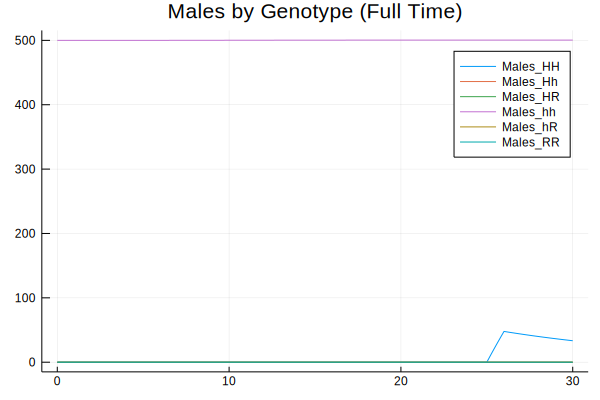

In [25]:
plot(sol_odecontNL.t, males_HH, label = "Males_HH", title = "Males by Genotype (Full Time)")
plot!(sol_odecontNL.t, males_Hh, label = "Males_Hh")
plot!(sol_odecontNL.t, males_HR, label = "Males_HR")
plot!(sol_odecontNL.t, males_hh, label = "Males_hh")
plot!(sol_odecontNL.t, males_hR, label = "Males_hR")
plot!(sol_odecontNL.t, males_RR, label = "Males_RR")

In [26]:
# list comprehensions return arrays; hence brackets
sumfemales_HH = [sum(val[20,:]) for val in sol_odecontNL.u]   
sumfemales_Hh = [sum(val[21,:]) for val in sol_odecontNL.u]
sumfemales_HR = [sum(val[22,:]) for val in sol_odecontNL.u]
sumfemales_hh = [sum(val[23,:]) for val in sol_odecontNL.u]
sumfemales_hR = [sum(val[24,:]) for val in sol_odecontNL.u]
sumfemales_RR = [sum(val[25,:]) for val in sol_odecontNL.u]
;

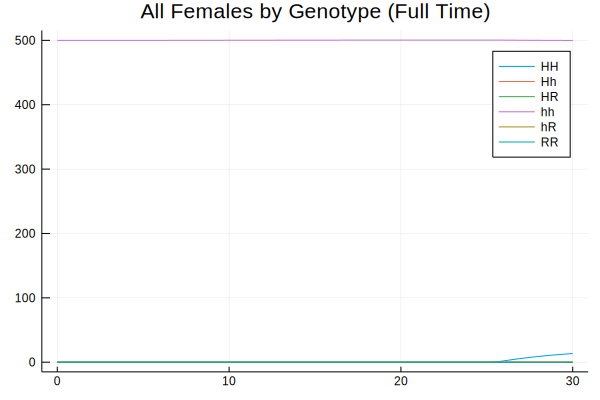

In [27]:
plot(sol_odecontNL.t, sumfemales_HH, label = "HH", title = "All Females by Genotype (Full Time)")
plot!(sol_odecontNL.t, sumfemales_Hh, label = "Hh")
plot!(sol_odecontNL.t, sumfemales_HR, label = "HR")
plot!(sol_odecontNL.t, sumfemales_hh, label = "hh")
plot!(sol_odecontNL.t, sumfemales_hR, label = "hR")
plot!(sol_odecontNL.t, sumfemales_RR, label = "RR")

In [28]:
#=

# Better way to set up the call backs from 
# https://discourse.julialang.org/t/integral-saturation-limits-w-differentialequations-jl/22143/8


# see also pakg fix at 
# https://github.com/JuliaDiffEq/DiffEqBase.jl/pull/207/commits/47d87398506e562e13c2e5083545568fb707145b

function condition1(u,t,integrator, ison)
    ison[1] ? func1(u)  :    # some default non-zero value?
end

function condition2(u,t,integrator, ison)
    ison[2] ? func2(u)  :    # some default non-zero value?
end

function affect(integrator, ison)
    # update integrator
    ison .= .!ison
end

ison = [true, false]
cb1 = ContinuousCallback((u,t,integrator)->condition1(u,t,integrator, Ref(ison)), 
                                            integrator -> affect(integrator, Ref(ison))
cb2 = ContinuousCallback((u,t,integrator)->condition2(u,t,integrator, Ref(ison)), 
                                            integrator -> affect(integrator, Ref(ison))

=#

# trying alternative to hard-coded du and u matrices 

    #=
    # Eggs 
    E = u[1:nE,:]   
    dE = @view du[1:nE,:]
    
    # Larvae
    L = u[nE+1 : nE+nL, :]             
    dL = @view du[nE+1 : nE+nL, :]

    # Pupae
    P = u[nE+nL+1 : nE+nL+nP,:] 
    dP = @view du[nE+nL+1 : nE+nL+nP, :]
    
    # Males 
    NM = u[nE+nL+nP+1, :]
    dNM = @view du[nE+nL+nP+1, :]
    
    # Females 
    NF = u[nE+nL+nP+2 : nE+nL+nP+2+nG,:]
    dNF = @view du[nE+nL+nP+2 : nE+nL+nP+2+nG,:]
    =#

In [29]:

#=

include("filepath_tofoo1")

function foo2()
    foo1()
end

=#